In [1]:
import sys
sys.path.append("./scripts/")
import math
import numpy as np
from gridmap import*
from robot import*
from astar import*
from dstar import*
from dstarlite import*
from bug import*
from dijkstra import PathNotCalculatedError
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [2]:
class PathFollower(Robot):
    def __init__(
        self, world, pp_algorithm, robot_color="black", path_color="red", r=0.02,
        noise_per_meter=5, noise_std=np.pi/60, bias_rate_stds=(0.0, 0.0),
        drawWayPoint_flag=False, drawMetricMap_flag=False
    ):
        super().__init__(
            None, agent=None, sensor=None, robot_color=robot_color, path_color=path_color, r=r,
            noise_per_meter=noise_per_meter, noise_std=noise_std, bias_rate_stds=bias_rate_stds,
            expected_stuck_time=1e100, expected_escape_time = 1e-100,
            expected_kidnap_time=1e1000, kidnap_range_x = (0.0,0.0), kidnap_range_y = (0.0,0.0)
        )
        self.world = world
        if np.any(self.world.start_index == None) or np.any(self.world.goal_index == None):
            theta = 0.0
        else:
            d_pose = self.world.goal_index - self.world.start_index
            theta = np.arctan2(d_pose[1], d_pose[0])
        self.pose = np.append(self.world.start_index * self.world.grid_step + self.world.grid_step / 2, theta)
        self.poses = [self.pose]
        self.pp_algorithm = pp_algorithm
        self.followIndex = self.world.start_index
        self.nu = 0.0
        self.nu_min = 0.0
        self.nu_max = 0.4
        self.nu_delta = 0.01
        self.omega = 0.0
        self.omega_min = -320*np.pi / 180
        self.omega_max = 320*np.pi / 180
        self.omega_delta = 10*np.pi / 180
        self.time_interval = self.world.time_interval
        self.way_point = self.world.goal_index
        
        self.drawWayPoint_flag = drawWayPoint_flag
        self.drawMetricMap_flag = drawMetricMap_flag
        
        self.flag_chng_index = True
    
    def run(self):
        d_pose = self.world.goal_index - self.world.start_index
        theta = np.arctan2(d_pose[1], d_pose[0])
        self.pose = np.append(self.world.start_index * self.world.grid_step + self.world.grid_step / 2, theta)
        while not self.isRobotInGoal(self.pose) and not self.isRobotInObstacle(self.pose):
            self.pose = self.next(self.pose)
            self.poses.append(self.pose)
            chk_interval = 30
            if len(self.poses) > chk_interval+1:
                distance = 0.0
                for i in range(chk_interval):
                    distance += np.abs(np.linalg.norm(self.poses[i-chk_interval][0:2] - self.poses[i-chk_interval-1][0:2]))
                if distance < np.linalg.norm(self.world.grid_step) * 1.0:
                    print("aaa")
                    break
        print(self.isRobotInGoal(self.pose), self.isRobotInObstacle(self.pose))
    
    def plot(self, figsize=(4, 4), color="red", save_path=None):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.world.grid_step[0] * self.world.grid_num[0])
        ax.set_ylim(0, self.world.grid_step[1] * self.world.grid_num[1])
        ax.set_xlabel("X", fontsize=10)
        ax.set_ylabel("Y", fontsize=10)

        # Map
        for index, grid in np.ndenumerate(self.world.grid_map):
            if grid == '0':
                self.world.drawGrid(index, "black", 1.0, ax)
            if grid == '2' or self.world.isStart(index):  #Start
                self.world.drawGrid(index, "orange", 1.0, ax)
            elif grid == '3' or self.world.isGoal(index):  #Goal 
                self.world.drawGrid(index, "green", 1.0, ax)
        
        self.drawTakenPath(self.poses, ax, linewidth=1.0, label="BUG")
        
        plt.show()

        if(save_path is not None):
            fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        return fig
    
    def draw(self, ax, elems):
        self.drawRobot(self.pose, ax, elems)
        self.drawTakenPath(self.poses, ax, elems, linewidth=1.0, label=self.pp_algorithm.pp_algorithm_name)
        if self.isRobotInGoal(self.pose) and not self.isRobotInObstacle(self.pose):
            return
        
        self.pose = self.next(self.pose)
        self.poses.append(self.pose)
        self.world.drawGrid(self.way_point, "blue", 0.5, ax, elems=elems)  if self.drawWayPoint_flag else None
        if hasattr(self.pp_algorithm, "checkNewObstacle"):
            self.pp_algorithm.drawNewObstacles(ax, elems) if not self.pp_algorithm.drawMetricMap_flag else None
        ax.legend(fontsize=15, framealpha=1.0, loc="upper right")
         
    def next(self, pose):
        index = self.poseToIndex(pose)
        next_index = index
        if hasattr(self.pp_algorithm, "checkNewObstacle"):
            self.pp_algorithm.checkNewObstacle(next_index)
        
        if self.flag_chng_index == True:
            prev_next = next_index
            while np.linalg.norm(self.pose[0:2] - self.indexToPose(next_index)[0:2]) < np.linalg.norm(self.world.grid_step)*0.5:
                try:
                    next_index = self.pp_algorithm.next(next_index)
                except PathNotCalculatedError:
                    self.pp_algorithm.run()
                    next_index = self.pp_algorithm.next(self.world.start_index)
                if np.any(next_index == None):
                    next_index = self.followIndex
                if self.world.isGoal(next_index):
                    break
                if np.all(index == next_index):
                    next_index = prev_next
                    break
                prev_next = next_index
            self.followIndex = next_index
        else:
            next_index = self.way_point
        if np.all(np.abs(next_index - index) == [1, 1]):
            if np.all(next_index - index == [1, 1]):
                if self.world.isObstacle(index + [1, 0]):
                    next_index = index + [0, 1]
                elif self.world.isObstacle(index + [0, 1]):
                    next_index = index + [1, 0]
            elif np.all(next_index - index == [-1, 1]):
                if self.world.isObstacle(index + [-1, 0]):
                    next_index = index + [0, 1]
                elif self.world.isObstacle(index + [0, 1]):
                    next_index = index + [-1, 0]
            elif np.all(next_index - index == [1, -1]):
                if self.world.isObstacle(index + [1, 0]):
                    next_index = index + [0, -1]
                elif self.world.isObstacle(index + [0, -1]):
                    next_index = index + [1, 0]
            elif np.all(next_index - index == [-1, -1]):
                if self.world.isObstacle(index + [-1, 0]):
                    next_index = index + [0, -1]
                elif self.world.isObstacle(index + [0, -1]):
                    next_index = index + [-1, 0]
        if self.flag_chng_index == True:
            self.way_point = next_index
        
        control_inputs = self.controlInputCandidate()
        path_candidates = self.pathCandidate(control_inputs)
        d_theta = np.arctan2(self.indexToPose(next_index)[1] - pose[1], self.indexToPose(next_index)[0] - pose[0]) - pose[2]
        while d_theta > np.pi:
            d_theta -= 2*np.pi
        while d_theta < -np.pi:
            d_theta += 2*np.pi
        if d_theta < -np.pi/6:
            nu, omega = 0.0, -320*np.pi/180
        elif d_theta > np.pi/6:
            nu, omega = 0.0, 320*np.pi/180
        else:
            nu, omega = self.selectPath(path_candidates, goalH=0.01)
        next_pose = self.state_transition(nu, omega, self.world.time_interval, pose)
        
        if np.linalg.norm(next_pose[0:2] - self.indexToPose(next_index)[0:2]) > np.linalg.norm(self.world.grid_step)/4:
            self.flag_chng_index = False
        else:
            self.flag_chng_index = True
        return  next_pose   
    
    def controlInputCandidate(self):
        controlInput = []
        for omega in np.arange(self.omega_min, self.omega_max, self.omega_delta):
            controlInput.append([self.nu_max, omega])
            controlInput.append([self.nu_max/2, omega])
            controlInput.append([0, omega])
            #controlInput.append([0.0, omega])
            #for nu in np.arange(self.nu-self.nu_acc, self.nu+self.nu_acc+1e-5, self.nu_delta):
            #    if (nu < self.nu_max and nu > self.nu_min) and (omega < self.omega_max and omega > self.omega_min):
            #        controlInput.append([nu, omega])
        return controlInput
    
    def pathCandidate(self, control_inputs):
        candidate_path = []
        for control_input in control_inputs:
            xs, ys, thetas = self.pose
            nu, omega = control_input
            path = [[xs, ys, thetas, 0.0, 0.0]]
            flag=0
            for i in range(3):
                xf, yf, thetaf = self.state_transition(nu, omega, self.world.time_interval, np.array([xs, ys, thetas]))
                if self.isRobotInObstacle([xf, yf, thetaf]):
                    flag=1
                    break
                path.append([xf, yf, thetaf, nu, omega])
                xs, ys, thetas = xf, yf, thetaf
            candidate_path.append(path) if flag==0 else None
        return candidate_path
    
    def selectPath(self, path_candidates, speed=10.0, goalH=0.0, goalD=1.0, obs=0.0):
        cost = float('inf')
        c_goalH_c = float('inf')
        c_goalD_c = float('inf')
        select_nu, select_omega = 0.0, 0.0
        for path in path_candidates:
            x, y, theta, nu, omega = path[-1]
            c_speed = self.costSpeed(nu)
            c_goalH = self.costGoalHeading([x, y, theta])
            c_goalD = self.costGoalDistance([x, y, theta])
            c_obs = self.costObstacle([x, y, theta]) if obs != 0.0 else 0.0
            c = c_speed*c_speed + goalH*c_goalH + goalD*c_goalD
            if(c < cost):
                cost = c
                select_nu, select_omega = nu, omega
        return select_nu, select_omega
    
    def costObstacle(self, pose):
        index = self.poseToIndex(pose)
        theta = pose[2]
        cost = 0.0
        for i in range(-1, 3):
            for j in range(-1, 3):
                if not self.isInRange(np.arctan2(j, i), theta-45, theta+45):
                    continue
                sensing_index = index + np.array([i, j])
                if self.world.isOutOfBounds(sensing_index):
                    cost += 1.0
                if self.world.isObstacle(sensing_index):
                    cost += 1.0 / (np.linalg.norm(pose[0:2] - self.indexToPose(sensing_index)[0:2])+1e-5)
        return cost
    
    def costSpeed(self, nu):
        return self.nu_max - nu
    
    def costGoalDistance(self, pose):
        cost = np.linalg.norm(pose[0:2] - self.indexToPose(self.way_point)[0:2])
        return cost
    
    def costGoalHeading(self, pose):
        theta = np.arctan2(self.indexToPose(self.way_point)[0:2][1] - pose[0:2][1], self.indexToPose(self.way_point)[0:2][0] - pose[0:2][0])
        d_theta = abs(pose[2] - theta)
        return d_theta

In [3]:
class BugFollower(PathFollower):
    def __init__(
        self, world, robot_color="black", path_color="red", r=0.02,
        noise_per_meter=5, noise_std=np.pi/60, bias_rate_stds=(0.0, 0.0),
        drawWayPoint_flag=False, drawMLine_flag=False
        
    ):
        super().__init__(
            world, BUG(world), robot_color=robot_color, path_color=path_color, r=r,
            noise_per_meter=5, noise_std=np.pi/60, bias_rate_stds=(0.0, 0.0),
            drawWayPoint_flag=drawWayPoint_flag
        )
        self.m_line = np.array([])
        self.drawMLine_flag = drawMLine_flag
    
    def initialize(self):
        self.m_line = np.array([])
        self.alongObstacle = False
        self.prev_index = None
        self.prev_next_index = None
        self.prev_obs = None
        self.v = np.array([])
        self.takenPath = []
        d_pose = self.world.goal_index - self.world.start_index
        theta = np.arctan2(d_pose[1], d_pose[0])
        self.pose = np.append(self.world.start_index * self.world.grid_step + self.world.grid_step / 2, 0)
        self.getMLine()
        self.mLine_min = float('inf')
        self.flag_chng_index = False
        self.way_point = self.world.goal_index
    
    def plot(self, figsize=(4, 4), color="red", save_path=None, drawMLine_flag=False):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.world.grid_step[0] * self.world.grid_num[0])
        ax.set_ylim(0, self.world.grid_step[1] * self.world.grid_num[1])
        ax.set_xlabel("X", fontsize=10)
        ax.set_ylabel("Y", fontsize=10)

        # Map
        for index, grid in np.ndenumerate(self.world.grid_map):
            if grid == '0':
                self.world.drawGrid(index, "black", 1.0, ax)
            if grid == '2' or self.world.isStart(index):  #Start
                self.world.drawGrid(index, "orange", 1.0, ax)
            elif grid == '3' or self.world.isGoal(index):  #Goal 
                self.world.drawGrid(index, "green", 1.0, ax)
        
        if(drawMLine_flag is True):
            for index in self.m_line:
                if (not self.world.isStart(index)) and (not self.world.isGoal(index)):
                    self.world.drawGrid(index, "lime", 0.5, ax)
        
        self.drawTakenPath(self.poses, ax, linewidth=1.0, label="BUG")
        
        plt.show()

        if(save_path is not None):
            fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        return fig
    
    def run(self):
        cnt = 0
        if(len(self.m_line) == 0):
            self.initialize()
            self.drawMLine(ax) if(self.drawMLine_flag is True) else None
        while (not self.isRobotInObstacle(self.pose)) and (not self.isRobotInGoal(self.pose)) and cnt < 20000:
            self.pose = self.next(self.pose)
            self.poses.append(self.pose)
            cnt += 1
        if self.isRobotInGoal(self.pose):
            print()
        else:
            print("  ", self.isRobotInObstacle(self.pose), self.isRobotInGoal(self.pose), cnt)
    
    def draw(self, ax, elems):
        self.drawRobot(self.pose, ax, elems)
        self.drawTakenPath(self.poses, ax, elems, linewidth=1.0, label="BUG")
        if(len(self.m_line) == 0):
            self.initialize()
            self.drawMLine(ax) if(self.drawMLine_flag is True) else None
        if self.isRobotInObstacle(self.pose):
            pass
        elif self.isRobotInGoal(self.pose):
            pass
        else:
            self.pose = self.next(self.pose)
        self.poses.append(self.pose)
        self.world.drawGrid(self.way_point, "blue", 0.5, ax, elems=elems) if self.drawWayPoint_flag else None
        ax.legend(fontsize=15, framealpha=1.0, loc="upper right")
    
    def next(self, pose):
        index = self.poseToIndex(pose)
        next_pose = None
        next_chk_pose = None
        
        if(len(self.m_line) == 0):
            raise PathNotCalculatedError("Path did not calculate")
        
        # 過去に通過したM-Lineよりも近いM-Lineにに到達した場合
        if np.any(np.all(self.m_line == index, axis=1)) and np.linalg.norm(self.indexToPose(self.world.goal_index)[0:2] - pose[0:2]) < self.mLine_min:
            self.alongObstacle = False
            #next_chk_index = index
            #dx, dy = index - self.world.goal_index
            #theta_g = np.arctan2(dy, dx)
            #theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            #neigbor_grid = np.argsort(theta_sort)[0]
            self.mLine_min = np.linalg.norm(self.indexToPose(self.world.goal_index)[0:2] - pose[0:2])
        
        # 前回，障害物がなかった場合
        if(self.alongObstacle is False):
            dx, dy = index - self.world.goal_index
            theta_g = np.arctan2(dy, dx)
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            neigbor_grid = np.argsort(theta_sort)[0]
            next_index = index + neigbor_grids[neigbor_grid]
            
            d_theta = np.arctan2(self.world.goal_index[1] - index[1], self.world.goal_index[0] - index[0]) - pose[2]
            while d_theta > np.pi:
                d_theta -= 2*np.pi
            while d_theta < -np.pi:
                d_theta += 2*np.pi
            if d_theta < -np.pi/9:
                nu, omega = 0.0, -320*np.pi/180
            elif d_theta > np.pi/9:
                nu, omega = 0.0, 320*np.pi/180
            elif d_theta < -np.pi/6:
                nu, omega = 0.1, -320*np.pi / 180
            elif d_theta > np.pi/6:
                nu, omega = 0.1, 320*np.pi / 180
            else:
                nu, omega = self.nu_max, d_theta*25
                
            next_pose = self.state_transition(nu, omega, self.world.time_interval, pose)
            if self.isRobotInObstacle(next_pose):
                chk_index = self.poseToIndex(next_pose)
                for grid in neigbor_grids:
                    neigbor_index = chk_index + grid
                    if self.world.isObstacle(neigbor_index):
                        neigbor_pose = self.indexToPose(neigbor_index)
                        dis_pose = np.abs(neigbor_pose - next_pose)[0:2] - self.world.grid_step / 2
                        if np.all(grid == [1, 0]) or np.all(grid == [-1, 0]):
                            dis = dis_pose[0]
                        elif np.all(grid == [0, 1]) or np.all(grid == [0, -1]):
                            dis = dis_pose[1]
                        elif np.all(grid == [1, 1]) or np.all(grid == [-1, -1]) or np.all(grid == [1, -1]) or np.all(grid == [-1, 1]):
                            if dis_pose[0] < self.r and dis_pose[1] < self.r:
                                next_index = neigbor_index
                                break
                            else:
                                continue
                        if dis < self.r:
                            next_index = neigbor_index
                            break
                
                self.alongObstacle = True
                self.flag_chng_index = True
                next_index = self.moveCW(index, next_index)
                self.way_point = next_index
                d_theta = np.arctan2(next_index[1] - index[1], next_index[0] - index[0]) - pose[2]
                while d_theta > np.pi:
                    d_theta -= 2*np.pi
                while d_theta < -np.pi:
                    d_theta += 2*np.pi
                if d_theta < -np.pi/3:
                    nu, omega = 0.0, -320*np.pi/180
                elif d_theta > np.pi/3:
                    nu, omega = 0.0, 320*np.pi/180
                else:
                    control_inputs = self.controlInputCandidate()
                    path_candidates = self.pathCandidate(control_inputs)
                    nu, omega = self.selectPath(path_candidates, speed=10.0, goalH=0.00, goalD=1.0)
                next_pose = self.state_transition(nu, omega, self.world.time_interval, pose)
            else:
                self.mLine_min = np.linalg.norm(self.indexToPose(self.world.goal_index)[0:2] - pose[0:2])
            self.v = index - next_index
            return next_pose
        
        if self.flag_chng_index:
            if self.world.isObstacle(self.prev_obs - self.v):
                next_index = self.moveCW(index, self.prev_obs - self.v)
            else:
                next_index = self.prev_obs - self.v
                if np.all(np.abs(next_index - index) == [1, 1]):
                    next_index = index - self.v
            self.v = index - next_index
            self.way_point = next_index
        else:
            next_index = self.way_point
        
        d_theta = np.arctan2(self.indexToPose(next_index)[1] - pose[1], self.indexToPose(next_index)[0] - pose[0]) - pose[2]
        while d_theta > np.pi:
            d_theta -= 2*np.pi
        while d_theta < -np.pi:
            d_theta += 2*np.pi
        if d_theta < -np.pi/6:
            nu, omega = 0.0, -np.pi
        elif d_theta > np.pi/6:
            nu, omega = 0.0, np.pi
        else:
            #nu, omega = self.nu_max, d_theta*30
            control_inputs = self.controlInputCandidate()
            path_candidates = self.pathCandidate(control_inputs)
            nu, omega = self.selectPath(path_candidates, speed=10.0, goalH=0.0001, goalD=1.0)
        next_pose = self.state_transition(nu, omega, self.world.time_interval, pose)
        
        if np.linalg.norm(next_pose[0:2] - self.indexToPose(next_index)[0:2]) > np.linalg.norm(self.world.grid_step)/4:
            self.flag_chng_index = False
        else:
            self.flag_chng_index = True
            
        return next_pose
    
    def controlInputCandidate(self):
        controlInput = []
        for omega in np.arange(self.omega_min, self.omega_max, self.omega_delta):
            controlInput.append([self.nu_max, omega])
            #controlInput.append([self.nu_max/2, omega])
            controlInput.append([0, omega])
            #controlInput.append([0.0, omega])
            #for nu in np.arange(self.nu-self.nu_acc, self.nu+self.nu_acc+1e-5, self.nu_delta):
            #    if (nu < self.nu_max and nu > self.nu_min) and (omega < self.omega_max and omega > self.omega_min):
            #        controlInput.append([nu, omega])
        return controlInput
    
    def pathCandidate(self, control_inputs):
        candidate_path = []
        for control_input in control_inputs:
            xs, ys, thetas = self.pose
            nu, omega = control_input
            path = [[xs, ys, thetas, 0.0, 0.0]]
            flag=0
            for i in range(1):
                xf, yf, thetaf = self.state_transition(nu, omega, self.world.time_interval, np.array([xs, ys, thetas]))
                if self.isRobotInObstacle([xf, yf, thetaf]):
                    flag=1
                    break
                path.append([xf, yf, thetaf, nu, omega])
                xs, ys, thetas = xf, yf, thetaf
            candidate_path.append(path) if flag==0 else None
        return candidate_path
    
    def getMLine(self):
        s = self.world.start_index
        g = self.world.goal_index
        theta = np.arctan2(g[1] - s[1], g[0] - s[0])
        self.m_line = np.array([s])
        distance = 0.0
        while distance <= np.linalg.norm(self.indexToPose(s)[0:2] - self.indexToPose(g)[0:2]):
            distance += np.linalg.norm(self.world.grid_step)*0.5
            pos = self.indexToPose(s)[0:2] + np.array([np.cos(theta), np.sin(theta)])*distance
            index = self.poseToIndex(pos)
            if not np.any([np.all(index == grid) for grid in self.m_line]):
                self.m_line = np.append(self.m_line, self.poseToIndex(pos).reshape(1, 2), axis=0)
    
    def moveCW(self, index, next_chk_index):# 左回りになるように移動
        dxy = index - next_chk_index
        if(np.all(dxy == [1, 0]) or np.all(dxy == [1, 1])): # 障害物が左側または左下側の場合，下へ移動する
            if not self.world.isObstacle(index + [0, -1]):
                next_index = index + [0, -1]
                self.prev_obs = index + [-1, 0]
            elif not self.world.isObstacle(index + [1, 0]):
                next_index = index + [1, 0]
                self.prev_obs = index + [0, -1]
            elif not self.world.isObstacle(index + [0, 1]):
                next_index = index + [0, 1]
                self.prev_obs = index + [1, 0]
            else:
                next_index = index + [-1, 0]
        elif(np.all(dxy == [1, -1]) or np.all(dxy == [0, -1])): # 障害物が左上側または上側の場合，左へ移動する
            if not self.world.isObstacle(index + [-1, 0]):
                next_index = index + [-1, 0]
                self.prev_obs = index + [0, 1]
            elif not self.world.isObstacle(index + [0, -1]):
                next_index = index + [0, -1]
                self.prev_obs = index + [-1, 0]
            elif not self.world.isObstacle(index + [1, 0]):
                next_index = index + [1, 0]
                self.prev_obs = index + [0, -1]
            else:
                next_index = index + [0, 1]
        elif(np.all(dxy == [-1, 0]) or np.all(dxy == [-1, -1])): # 障害物が右側または右上側の場合，上へ移動する
            if not self.world.isObstacle(index + [0, 1]):
                next_index = index + [0, 1]
                self.prev_obs = index + [1, 0]
            elif not self.world.isObstacle(index + [-1, 0]):
                next_index = index + [-1, 0]
                self.prev_obs = index + [0, 1]
            elif not self.world.isObstacle(index + [0, -1]):
                next_index = index + [0, -1]
                self.prev_obs = index + [-1, 0]
            else:
                next_index = index + [1, 0]
        elif(np.all(dxy == [-1, 1]) or np.all(dxy == [0, 1])): # 障害物が下側または左下側の場合，右へ移動する
            if not self.world.isObstacle(index + [1, 0]):
                next_index = index + [1, 0]
                self.prev_obs = index + [0, -1]
            elif not self.world.isObstacle(index + [0, 1]):
                next_index = index + [0, 1]
                self.prev_obs = index + [1, 0]
            elif not self.world.isObstacle(index + [-1, 0]):
                next_index = index + [-1, 0]
                self.prev_obs = index + [0, 1]
            else:
                next_index = index + [0, 1]
        return next_index

    def drawMLine(self, ax):
        for line in self.m_line:
            if not(self.world.isStart(line) or self.world.isGoal(line)):
                self.world.drawGrid(line, "lime", 0.5, ax)

[2 2] [28  9]


<IPython.core.display.Javascript object>


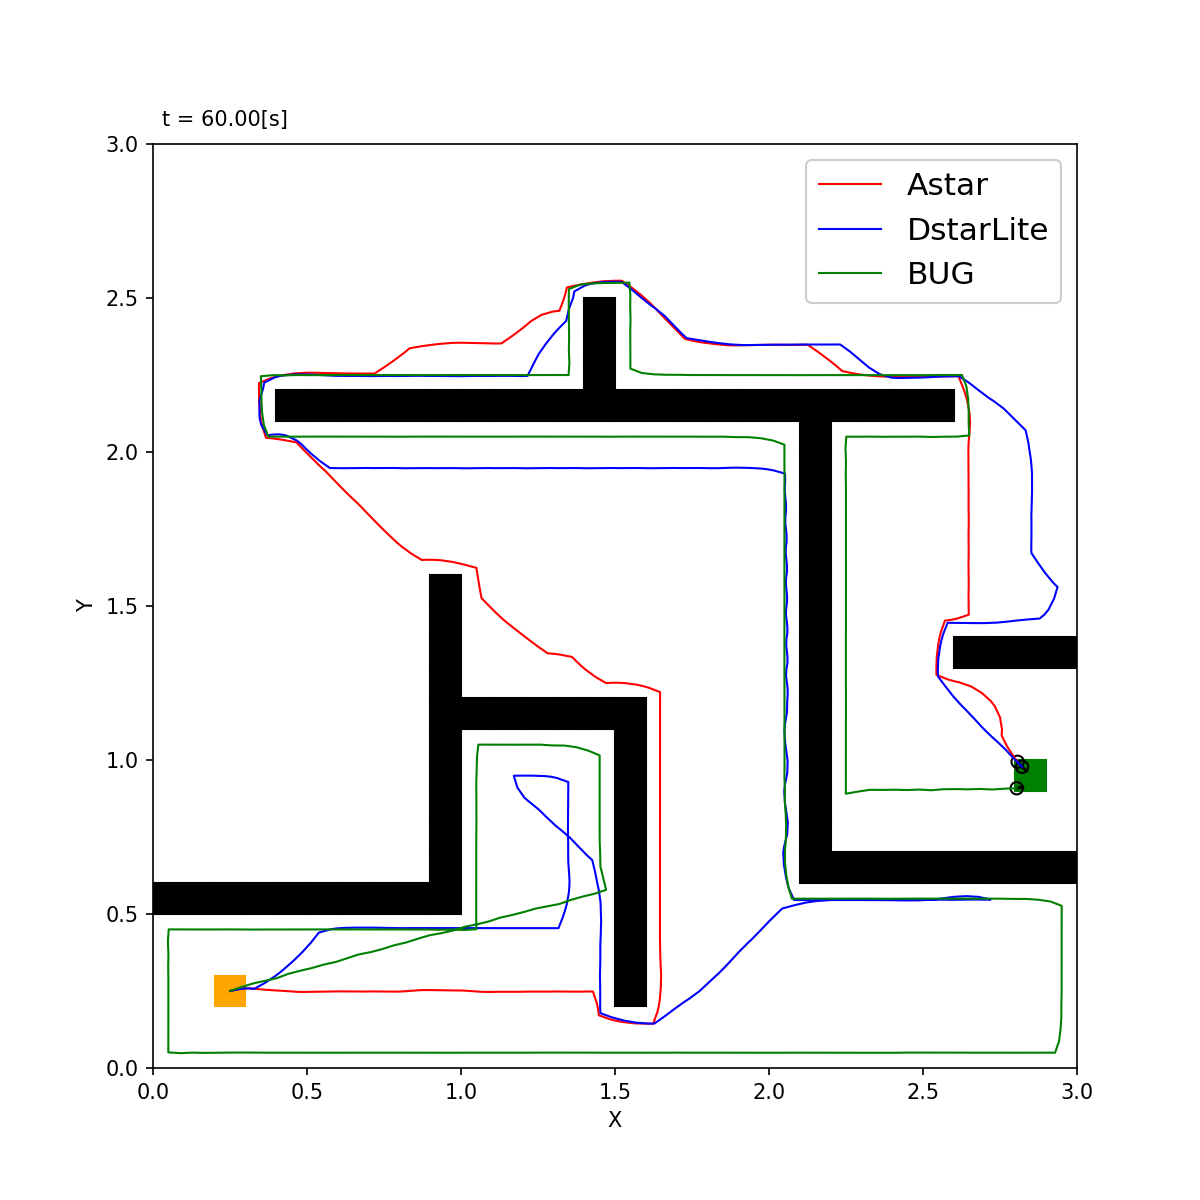

In [4]:
if __name__ == "__main__":
    time_span = 60
    time_interval = 0.1

    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])

    map_data = "./csvmap/map2.csv"

    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, time_show="time", debug=False, is_dynamic=False)
    print(world.start_index, world.goal_index)
    
    pp_algorithm = Astar(world)
    world.append(PathFollower(world, pp_algorithm, path_color="red"))
    
    pp_algorithm = DstarLite(world, drawMetricMap_flag=True)
    world.append(PathFollower(world, pp_algorithm, path_color="blue"))
    
    bug_follower = BugFollower(world, path_color="green")
    world.append(bug_follower)
    
    world.draw(figsize=(8, 8))
    #world.ani.save('path_45_compare3.gif', writer='ffmpeg', fps=100)    #アニメーション保存

In [5]:
# time_span = 80
# time_interval = 0.1

# grid_step = np.array([0.1, 0.1])
# grid_num = np.array([100, 100])

# map_data = "./csvmap/mr/map_45.csv"
# map_data = "./csvmap/map3.csv"

# world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, time_show="time", debug=False, is_dynamic=False)
# for i in range(10):
#     world.resetStartAndGoal()
#     print(world.start_index, world.goal_index, end="")
#     path_follower = BugFollower(world, path_color="green")
#     #path_follower = PathFollower(world, Astar(world))
#     #path_follower = PathFollower(world, DstarLite(world))
#     path_follower.run()
#     path_follower.plot()